In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance
from torchvision import transforms
import torch
import torch.nn as nn

In [2]:
def occlude(img, x, y, w = 50, h = 50, rgb = (80,80,80)):
    img[x:x + w,y:y + h] = rgb
    return img
    

In [3]:
preprocess1 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

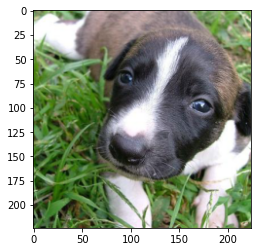

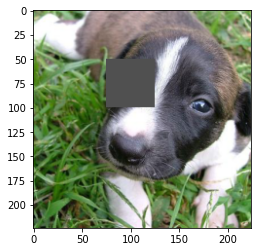

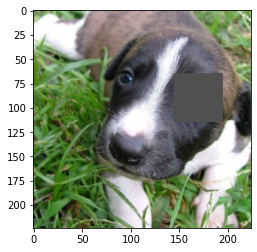

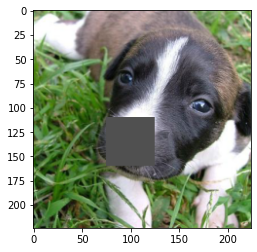

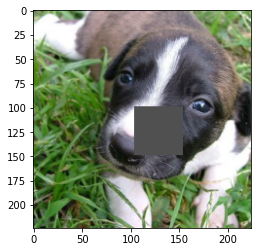

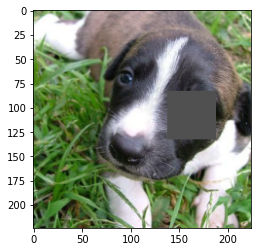

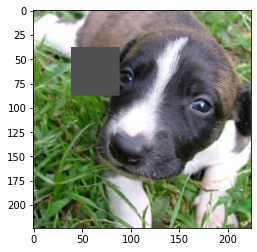

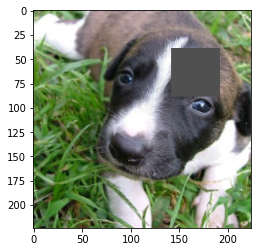

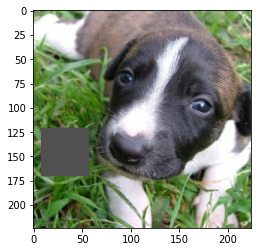

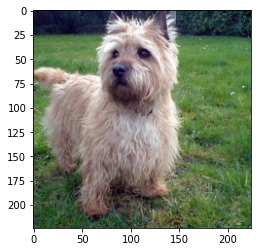

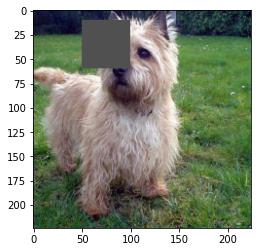

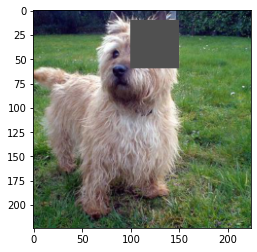

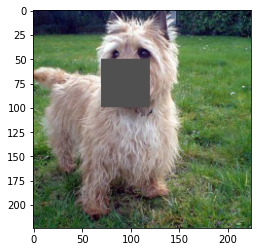

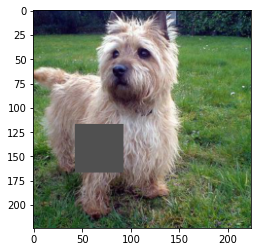

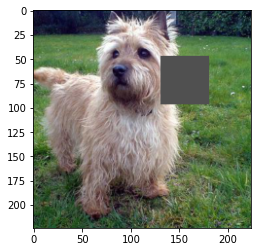

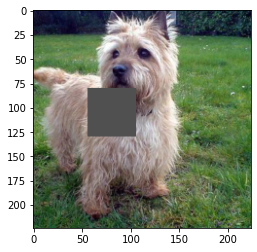

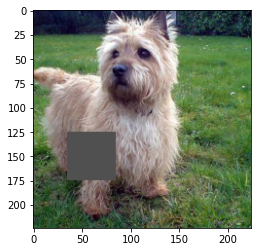

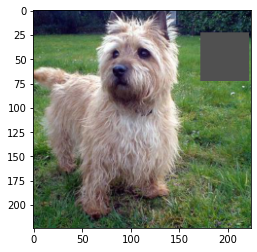

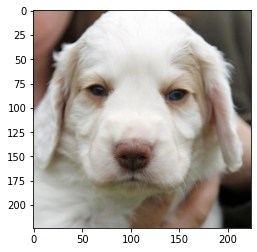

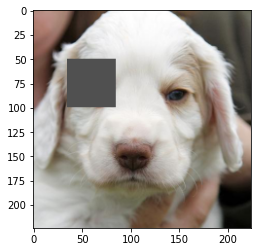

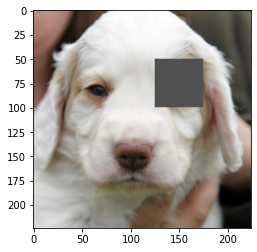

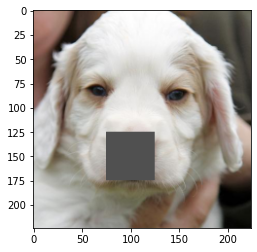

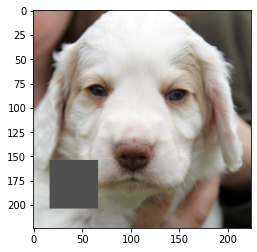

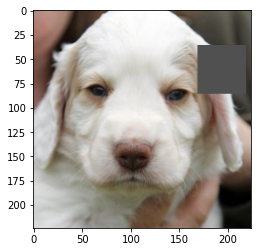

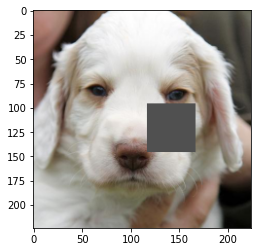

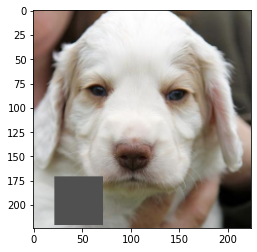

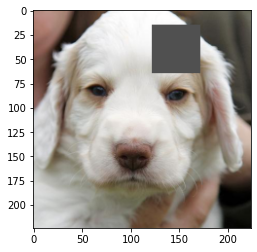

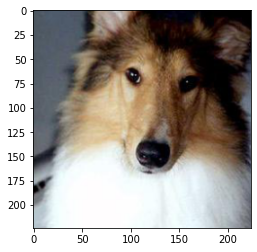

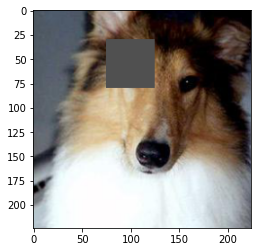

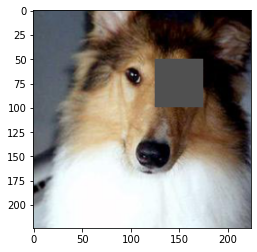

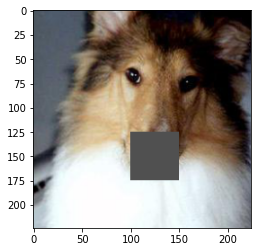

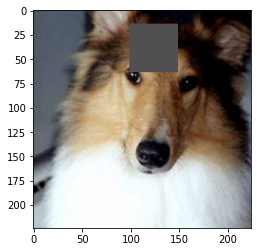

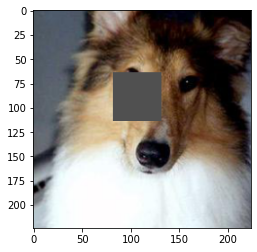

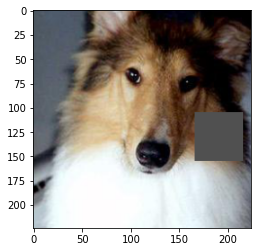

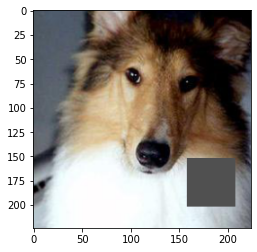

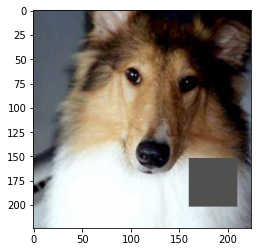

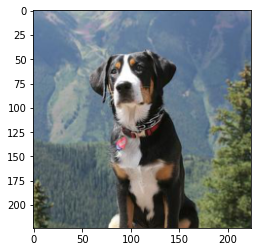

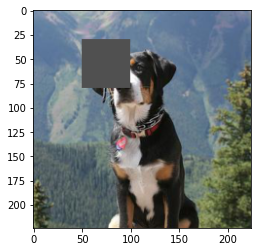

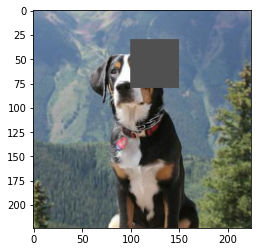

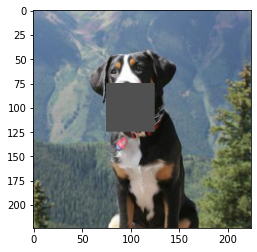

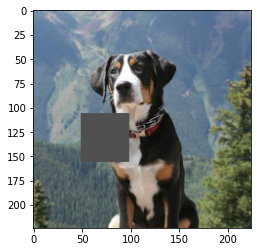

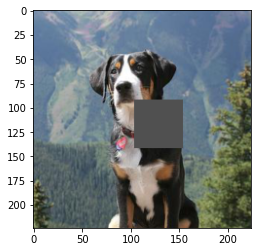

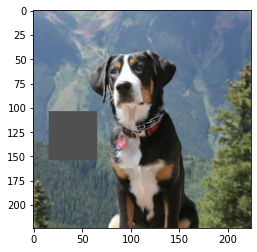

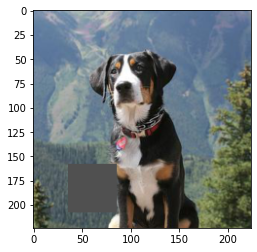

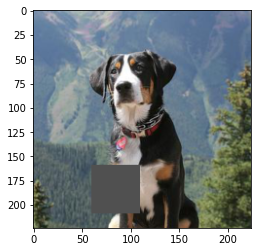

In [4]:
input_image_names = ['n02091134_2235.jpg', 'n02096177_91.jpg', 'n02101556_3100.jpg', 'n02106030_3948.jpg', 'n02107574_322.jpg']
left_eye_boxes = [[50,75], [10,50], [50,35], [30,75], [30,50]]
right_eye_boxes = [[65,145], [10,100], [50,125], [50,125], [30,100]]
nose_boxes = [[110,75], [50,70], [125,75], [125,100], [75,75]]
images = np.zeros((5,9,224,224,3))
for i, img in enumerate(input_image_names):
    input_image = Image.open(f'occlusion/{img}')
    input_tensor = preprocess1(input_image)
    input_batch = input_tensor.unsqueeze(0)
    orig_img = np.asarray(transforms.ToPILImage()(input_batch[0]).convert("RGB"), dtype=np.uint8)
    left_eye_img =  orig_img.copy()
    right_eye_img =  orig_img.copy()
    nose_img =  orig_img.copy()
    left_eye_img =  occlude(left_eye_img, left_eye_boxes[i][0], left_eye_boxes[i][1], 50, 50, (80,80,80))
    right_eye_img =  occlude(right_eye_img, right_eye_boxes[i][0], right_eye_boxes[i][1], 50, 50, (80,80,80))
    nose_img =  occlude(nose_img, nose_boxes[i][0], nose_boxes[i][1], 50, 50, (80,80,80))
#     left_eye_img[left_eye_boxes[i][0]:left_eye_boxes[i][0] + 50,left_eye_boxes[i][1]:left_eye_boxes[i][1] + 50] = (80,80,80)
#     right_eye_img[right_eye_boxes[i][0]:right_eye_boxes[i][0] + 50,right_eye_boxes[i][1]:right_eye_boxes[i][1] + 50] = (80,80,80)
#     nose_img[nose_boxes[i][0]:nose_boxes[i][0] + 50,nose_boxes[i][1]:nose_boxes[i][1] + 50] = (80,80,80)
    images[i,0,:,:,:] = orig_img
    images[i,1,:,:,:] = left_eye_img
    images[i,2,:,:,:] = right_eye_img
    images[i,3,:,:,:] = nose_img
    for j in range(5):
        x, y = np.random.randint(0, 223 - 50), np.random.randint(0, 223 - 50)
        new_img =  orig_img.copy()
        new_img = occlude(new_img, x, y, 50, 50, (80,80,80))
        images[i,4+j,:,:,:] = new_img

images_pil = []
        
for i in range(5):
    images_pil.append([])
    for j in range(9):
        new_img = images[i,j]
        images_pil[i].append(Image.fromarray(images[i,j].astype('uint8')))
        plt.imshow(new_img.astype('uint8'))
        plt.show()

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /home/vamsheedar/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
input_batches = []
for i in range(5):
    for j in range(9):
        input_tensor = preprocess2(images_pil[i][j])
        input_batch = input_tensor.unsqueeze(0)
        input_batches.append(input_batch)
        transforms.ToPILImage()(input_tensor).convert("RGB")

In [7]:
class Alex(torch.nn.Module):
    def __init__(self):
        super(Alex, self).__init__()
        pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
        features = list(pretrained.features)
        classifier = list(pretrained.classifier)
        self.features = nn.ModuleList(features).eval() 
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.ModuleList(classifier).eval() 
        
    def forward(self, x):
        self.results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {2,5,7,9,12}:
#                 print(ii, x.shape)
                self.results.append(x.detach().numpy())
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for ii,model in enumerate(self.classifier):
            x = model(x)
#             print(ii, x.shape)
#             if ii in {2,5,7,9,12}:
#                 self.results.append(x.detach().numpy())
        return x, self.results

In [8]:
alex = Alex()

Using cache found in /home/vamsheedar/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
alex, alex(input_batches[0])

(Alex(
   (features): ModuleList(
     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace=True)
     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace=True)
     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace=True)
     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace=True)
     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
   (classifier): ModuleList(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=9216, out_features=4

In [10]:
alex(input_batches[0])[0][0], torch.nn.functional.softmax(alex(input_batches[0])[0][0], dim=0)

(tensor([ 1.2224e+00, -5.4210e+00, -2.7916e+00, -2.1295e+00, -1.7963e+00,
         -2.1473e+00,  1.1824e-01, -2.1432e+00,  1.8427e-01, -6.5538e+00,
          1.6631e-01, -2.9045e+00, -3.6887e+00,  1.2872e+00, -1.8605e+00,
          1.9093e-01,  1.2431e+00, -1.5487e+00,  7.2086e+00,  6.9368e-01,
          9.8763e-01, -1.3919e+00, -3.1124e+00,  3.9242e+00, -1.0144e+00,
          1.5818e+00, -1.0825e-01, -1.7302e+00,  8.2150e-01, -5.1891e-01,
         -2.1676e-02, -2.8649e+00,  7.1087e-01,  2.1409e-01, -1.3429e-01,
          2.5204e+00,  7.0701e+00,  1.8965e+00,  8.0353e-01, -7.6470e-01,
         -1.8018e+00, -3.9750e+00, -1.5763e+00,  6.8189e-01, -3.2444e+00,
         -6.5894e-01, -2.0087e+00, -9.6629e-01, -3.5810e-01, -2.8406e+00,
         -3.7061e+00, -1.0345e+00, -1.6195e+00, -1.5635e+00,  2.4300e+00,
         -1.6075e+00,  1.2688e+00, -3.7863e+00, -2.6315e+00, -2.5583e+00,
         -1.1817e+00,  1.0009e+00,  9.3205e-01,  2.2884e-01, -1.1196e+00,
         -9.8833e-01, -2.2728e+00, -2.

In [11]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-11-30 10:23:30--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.7’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2021-11-30 10:23:30 (7.63 MB/s) - ‘imagenet_classes.txt.7’ saved [10472/10472]



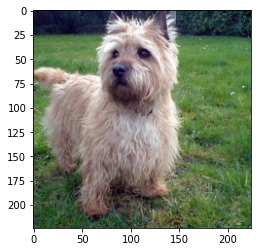

In [12]:
plt.imshow(images[1][0].astype('uint8'))
plt.show()

In [13]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
def run_alex_from_np_img(img):
    img_pil = Image.fromarray(img.astype('uint8'))
    input_tensor = preprocess2(img_pil)
    input_batch = input_tensor.unsqueeze(0)
    probs = torch.nn.functional.softmax(alex(input_batch)[0][0], dim=0)
    top5_prob, top5_catid = torch.topk(probs, 5)
#     print(top5_catid)
#     for i in range(top5_prob.size(0)):
#         print(categories[top5_catid[i]], top5_prob[i].item())
    return top5_prob, top5_catid, probs


In [14]:
categories = np.array(categories)
print(np.argwhere(categories=='whippet'))
print(np.argwhere(categories=='cairn'))
print(np.argwhere(categories=='clumber'))
print(np.argwhere(categories=='collie'))
print(np.argwhere(categories=='Greater Swiss Mountain dog'))
# categories

[[172]]
[[192]]
[[216]]
[[231]]
[[238]]


In [ ]:
outputs = []
for i in range(5):
    outputs.append([])
    for j in range(9):
        outputs[i].append(alex(input_batches[i*5+j]))
    

In [ ]:
outputs = np.array(outputs)

In [ ]:
outputs

In [ ]:
def epsilon_score(outputs=outputs):
    e = []
    for i in range(5):
        e.append([])
        for j in range(8):
            e[i].append([])
            for l in range(5):
                el = outputs[i][0][l] - outputs[i][j+1][l] 
                e[i][j].append(el)
    return e

In [ ]:
epsilon_score()

In [ ]:
def del_score(e=e):
    delta = np.zeros(())
    for i in range(5):
        for j in range(8):
        for j in range(8):
            if i==j:
                continue
            